In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from datetime import time
from datetime import timedelta
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz
import warnings
warnings.filterwarnings("ignore")

In [2]:
### ONLY RUN ONCE! ###
#download data from firebase
try:
    firebase_admin.delete_app(app)
except:
    print('making new app')
cred = credentials.Certificate("fb_key.json")
app = firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

making new app


In [3]:
## ONLY RUN TO REFRESH DATA! ###
ref = db.reference('/')
data = ref.get()

### RUN TO SAVE JSON FILE LOCALLY ###
with open('latest_data.json', 'w') as f:
    json.dump(data, f)

In [4]:
def to_datetime(dates, tz_aware=True):
    dt = []
    for i in dates:
        i = i.replace('T','_')
        i = i.replace('-','')
        i = i.replace(' ', '_')
        try:
            i_dt = datetime.strptime(i, '%Y%m%d_%H:%M:%S')
        except:
            print(i)
        if tz_aware:
            tz = pytz.timezone('US/Eastern')
            i_dt = tz.localize(i_dt)

        dt.append(i_dt)
    return np.array(dt)

In [5]:
## information regarding sensor installments/removals
## ID - biomass sensor (not algae tank)
df_anomaly = pd.read_csv('sensor_log.csv')
df_anomaly['datetime'] = to_datetime(df_anomaly.Date)

## information regarding algae harvests
## Before - algae (kg) in tank before harvest
## After  - algae (kg) in tank after harvest
## ID - algae tank
df_harvest = pd.read_csv('harvest_data.csv')
df_harvest['datetime'] = to_datetime(df_harvest.date)

# Get biomass sensor into object

In [6]:
def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')

class bmass_sensor():

    def __init__(self, name, data):
        self.d_dt = to_datetime(data[name]['data'])
        self.s_dt = to_datetime(data[name]['status'])
        self.on = np.array([int(data[name]['data'][i][1]) for i in data[name]['data']])
        self.off = np.array([int(data[name]['data'][i][0]) for i in data[name]['data']])
        self.g = np.array([int(data[name]['data'][i][2]) for i in data[name]['data']])
        self.battv = np.array([float(data[name]['status'][i]['batt_v']) for i in data[name]['status']])
        self.id = int(name[-1])


bm1 = bmass_sensor('bmass_1', data)
bm2 = bmass_sensor('bmass_2', data)
bm3 = bmass_sensor('bmass_3', data)
bm4 = bmass_sensor('bmass_4', data)
bm5 = bmass_sensor('bmass_5', data)

# Create biomass dataframe and save into csv file

In [7]:
def to_csv(bm1, filename = 'bm1_alisa.csv'):
    bm1_df = pd.DataFrame(columns=['dates', 'on', 'off', 'g_val'])
    bm1_df['dates'] = bm1.d_dt
    bm1_df['on'] = bm1.on
    bm1_df['off'] = bm1.off
    bm1_df['g_val'] = bm1.g
    bm1_df['times'] = bm1_df['dates'].dt.time
    bm1_df.to_csv(filename, index=False)
    return bm1_df

In [8]:
bm1_df = to_csv(bm1, 'bm1_raw.csv')
bm2_df = to_csv(bm2, 'bm2_raw.csv')
bm3_df = to_csv(bm3, 'bm3_raw.csv')
bm4_df = to_csv(bm4, 'bm4_raw.csv')
bm5_df = to_csv(bm5, 'bm5_raw.csv')

# Separate day and night time and save to CSV file

In [141]:
def sep_day_night(bm1_df, is_save, filename = 'bm1_alisa', from_time = 10, to_time = 16):
    # Filter data for the specified time range (10 AM to 4 PM)
    start_time = pd.to_datetime(str(from_time) + ':00:00').time()
    end_time = pd.to_datetime(str(to_time) + ':00:00').time()

    # Filter data for the specified time range (10 AM to 4 PM)
    ft = (from_time + 12) % 24
    tt = (to_time + 12) % 24 
    start_time2 = pd.to_datetime(str(ft) + ':00:00').time()
    end_time2 = pd.to_datetime(str(tt) + ':00:00').time()
    
    daytime_data = bm1_df[(bm1_df['times'] >= start_time) & (bm1_df['times'] <= end_time)]
    nighttime_data = bm1_df[(bm1_df['times'] >= start_time2) | (bm1_df['times'] <= end_time2)]
    
    if is_save:
        daytime_data.to_csv(filename + '_day.csv', index=False)
        nighttime_data.to_csv(filename + '_night.csv', index=False)
    
    return daytime_data, nighttime_data

In [10]:
day_bm1, night_bm1 = sep_day_night(bm1_df, is_save = True, filename = 'bm1_raw', from_time = 10, to_time = 16)
day_bm2, night_bm2 = sep_day_night(bm2_df, is_save = True, filename = 'bm2_raw', from_time = 10, to_time = 16)
day_bm3, night_bm3 = sep_day_night(bm3_df, is_save = True, filename = 'bm3_raw', from_time = 10, to_time = 16)
day_bm4, night_bm4 = sep_day_night(bm4_df, is_save = True, filename = 'bm4_raw', from_time = 10, to_time = 16)
day_bm5, night_bm5 = sep_day_night(bm5_df, is_save = True, filename = 'bm5_raw', from_time = 10, to_time = 16)

# Setting datetime as int

In [11]:
def average_by_hours(df, dates = 'dates', param = 'delta', result = 'avg', hours = 3):
    df[result] = 0

    for i in range(len(df)):
        
        begin = df[dates].iloc[i] - timedelta(hours=hours)
        end = df[dates].iloc[i] + timedelta(hours=hours)
        df_start = df[df[dates] >= begin]

        if len(df_start) == 0:
            df[result][i] = 0
            break
        if len(df_start) == 1:
            df[result][i] = df_start[result].iloc[0]
        else:
            df_start = df_start[df_start[dates] < end]
            df[result].iloc[i] = np.mean(df_start[param])
        
    return df

def set_df(sensor1):
#     sensor1['avg'] = moving_average(sensor1['g_val'], 18)
    sensor1['dates'] = pd.to_datetime(sensor1['dates'], errors='coerce')
    sensor1 = average_by_hours(sensor1, dates = 'dates', param = 'g_val', result = 'avg', hours = 3)
    sensor1['delta'] = sensor1['g_val']
    
#     print(sensor1['dates'].iloc[0])
    def date_2_int(sensor):
        for i in range(len(sensor)):
            dt = sensor['dates'].iloc[i]
            y = dt.year - 1
            M = dt.month
            d = dt.day - 1
            H = dt.hour
            m = dt.minute
            s = dt.second
            mm = 0
            if M == 1:
                mm = 0
            if M == 2:
                mm = 31
            if M == 3:
                mm = 31 + 29
            if M == 4:
                mm = 31 + 29 + 31
            if M == 5:
                mm = 31 + 29 + 31 + 30
            if M == 6:
                mm = 31 + 29 + 31 + 30 + 31
            if M == 7:
                mm = 31 + 29 + 31 + 30 + 31 + 30
            if M == 8:
                mm = 31 + 29 + 31 + 30 + 31 + 30 + 31
            if M == 9:
                mm = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 31
            if M == 10:
                mm = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 31 + 30
            if M == 11:
                mm = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 31 + 30 + 31
            if M == 12:
                mm = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 31 + 30 + 31 + 30
            sensor['int_dates'].iloc[i] = (((((y * 366 + mm) + d) * 24 + H) * 60) + m)
        return sensor
    sensor1['int_dates'] = 0
    sensor1 = date_2_int(sensor1)

    sensor1 = sensor1[sensor1['delta'] >= 50]
    sensor1 = sensor1[sensor1['delta'] < 11250]
    return sensor1

# Find the first thursday on this data collection

In [12]:
def onDay(date, day):
    """
    Returns the date of the next given weekday after
    the given date. For example, the date of next Monday.

    NB: if it IS the day we're looking for, this returns 0.
    consider then doing onDay(foo, day + 1).
    """
    days = (day - date.weekday() + 7) % 7
    return date + timedelta(days=days)

# Separate harvest weekly (Can be modified the code using harvest day, but until now, it is ok)

In [17]:
def separate_harvest(sensor_df, cal_harvest = False, remove_install = False, show_running = False):
    first_week = onDay(sensor_df['dates'].iloc[0], 3)
    first_end_week = first_week.replace(hour=8, minute=0)
    if show_running:
        print('first_week', first_end_week)
    
    weeks = sensor_df.copy()
    # remove installation period
    if remove_install:
        weeks = weeks[weeks['dates'] >= weeks['dates'].iloc[0] + timedelta(hours=2)]
    else:
        weeks = weeks[weeks['dates'] >= weeks['dates'].iloc[0]]

    list_weeks_df = []
    i = 0
    while True:
        if i == 0:
            end_week = first_end_week
        else:
            end_week = end_week + timedelta(days=7)

        interval_data = weeks[weeks['dates'] < end_week]
        if len(interval_data) <= 1:
            i += 1
            continue

        if show_running:
            print('week', i+1, "cut_off:", end_week)
            print(interval_data.head())
            print('start value of week', interval_data['avg'].iloc[0])
            print('end value of week', interval_data['avg'].iloc[-1])
        val_end_week = interval_data['avg'].iloc[-1]
        if remove_install:
            after_weeks = weeks[weeks['dates'] >= end_week + timedelta(hours=2)]
        else:
            after_weeks = weeks[weeks['dates'] >= end_week]
            
        if len(after_weeks) <= 1:
            # done
            if show_running:
                print('use the week')
            list_weeks_df.append(interval_data)
            break
            
        if show_running:
            print('start value of next week', after_weeks['avg'].iloc[0])
        val_next_week = after_weeks['avg'].iloc[0]
        
        if show_running:
            plt.plot(interval_data['dates'], interval_data['avg'], '.')
            plt.xticks(rotation=90)
            plt.show()
        i = i+1

        if not cal_harvest or (val_end_week > val_next_week + 10 or interval_data['avg'].iloc[0] + 10 > val_end_week):
            if show_running:
                print('use the week')
            list_weeks_df.append(interval_data)
            weeks = after_weeks

            if len(weeks) <= 1:
                break
                
    return list_weeks_df

# Do RANSAC to remove outliner data (weekly)

In [14]:
def convert_numpy(df):
    data1 = df['delta'].to_numpy()
    data1 = np.reshape(data1, (-1, 1))
    data0 = df['int_dates'].to_numpy()
    data0 = np.reshape(data0, (-1, 1))
    
    return np.concatenate((data0, data1), axis=1)

def fit_poly_ransac(df, degree=3, iterations=100, distance_threshold = 10):
    best_poly = None
    best_inliers = []
    data = convert_numpy(df)
    for _ in range(iterations):
        # Randomly sample points from the data
        if (len(data) < degree + 14):
            sample_indices = np.random.choice(len(data), size=len(data) - 1, replace=False)
        else:
            sample_indices = np.random.choice(len(data), size=degree + 14, replace=False)
        sample_x = data[sample_indices, 0]
        sample_y = data[sample_indices, 1]
        
        # Fit a polynomial to the sampled points
        poly = np.polyfit(sample_x, sample_y, degree)
        
        # Compute distances from the polynomial for all points
        distances = np.abs(np.polyval(poly, data[:, 0]) - data[:, 1])
        
        # Identify inliers (points within the threshold)
        inliers = data[distances < distance_threshold]
        
        # Update the best polynomial if the current model has more inliers
        if len(inliers) > len(best_inliers):
            best_poly = poly
            best_inliers = inliers
            df['distance'] = distances

    # Calculate distances from each point to the RANSAC polynomial
    distances_to_poly = np.abs(np.polyval(best_poly, data[:, 0]) - data[:, 1])

    # Separate points based on distance threshold
    inliner_points = data[distances_to_poly < distance_threshold]
    outliner_points = data[distances_to_poly >= distance_threshold]
    
    return best_poly, best_inliers, inliner_points, outliner_points, df, data

def apply_ransac(a_week, iterations, distance_threshold, degree=3, show_running = False):
    # Apply RANSAC to fit a cubic polynomial
    best_poly, best_inliers, inliner_points, outliner_points, df, data = fit_poly_ransac(a_week, degree=degree, iterations=iterations, distance_threshold = distance_threshold)

    # plt.plot(df['int_dates'], df['delta'],'.')
    # plt.show()
    # plt.plot(data[:,0], data[:,1],'.')
    # plt.show()

    # Plot the results
    if show_running:
        plt.scatter(outliner_points[:, 0], outliner_points[:, 1], label='Outliner Points (Red)', color='red')
        plt.scatter(inliner_points[:, 0], inliner_points[:, 1], label='Inliner Points (Blue)', color='blue')

        # Plot the RANSAC polynomial
        x_poly = np.linspace(data[:, 0].min(), data[:, 0].max(), 100)
        y_poly = np.polyval(best_poly, x_poly)
        plt.plot(x_poly, y_poly, label='RANSAC Polynomial', color='black')

        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Points Near and Far from RANSAC Polynomial (Cubic)')
        plt.show()
    return df

In [155]:
def plot_sensor_result(nightbm, new_sensor1_night):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(nightbm['dates'], nightbm['delta'],'r.')
    ax.plot(new_sensor1_night['dates'], new_sensor1_night['delta'],'b.')
    plt.legend(['raw data','filtered data'], loc='upper right')
    plt.xticks(rotation=90)
    plt.show()

def plot_sensor_clean(sensor1_clean, nonfilter_color = 'r', filter_color = 'k'):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(sensor1_clean['dates'], sensor1_clean['delta'], nonfilter_color + '.', linewidth=2)
    ax.plot(sensor1_clean['dates'], sensor1_clean['avg_clean'], filter_color + '-', linewidth=1)
    plt.legend(['real points','moving average'], loc='upper right')
    plt.xticks(rotation=90)
    plt.show()
    
def plot_sensor_avg_compare(sensor1_unclean, sensor1_clean):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(sensor1_unclean['dates'], sensor1_unclean['avg_clean'], 'r-', linewidth=1)
    ax.plot(sensor1_clean['dates'], sensor1_clean['avg_clean'], 'k-', linewidth=1)
    plt.legend(['sensor unclean','sensor clean'], loc='upper right')
    plt.xticks(rotation=90)
    plt.show()

def process_ransac_all(night_bm1, show_running = False, show_final = True):
    nightbm = set_df(night_bm1)
    first_week = onDay(nightbm['dates'].iloc[0], 3)
    first_end_week = first_week.replace(hour=8, minute=0)
    # separate weekly
    sensor1_weeks = separate_harvest(nightbm, cal_harvest = False, remove_install = False, show_running = show_running)

    # do RANSAC
    i = 0
    threshold = 300
    it = 50000
    new_dfs = []
    for week in sensor1_weeks:
        if show_running:
            print('week:', i+1)
        df = apply_ransac(week, it, threshold, show_running = show_running)
        new_dfs.append(df)
        i += 1

    # filter outliner
    dfs = []
    for ndf in new_dfs:
        df = ndf[ndf['distance'] < threshold * 1.1]
        dfs.append(df)
        if show_running:
            plt.plot(df['dates'], df['delta'],'.')
            plt.xticks(rotation=90)
            plt.show()

    # combine weekly to all data again
    new_sensor1_night = pd.concat(dfs)
    new_sensor1_night.head()

    if show_final:
        plot_sensor_result(nightbm, new_sensor1_night)

    sensor1_clean = average_by_hours(new_sensor1_night, dates = 'dates', param = 'delta', result = 'avg_clean', hours = 3)
    if show_final:
        plot_sensor_clean(sensor1_clean, nonfilter_color = 'r', filter_color = 'k')
        
    return sensor1_clean, nightbm

# Clean (filter) outliner points out

In [143]:
sensor1_clean_night, sensor1_night = process_ransac_all(night_bm1, show_running = False, show_final = False)
sensor4_clean_night, sensor4_night = process_ransac_all(night_bm4, show_running = False, show_final = False)
sensor5_clean_night, sensor5_night = process_ransac_all(night_bm5, show_running = False, show_final = False)

sensor1_clean_day, sensor1_day = process_ransac_all(day_bm1, show_running = False, show_final = False)
sensor4_clean_day, sensor4_day = process_ransac_all(day_bm4, show_running = False, show_final = False)
sensor5_clean_day, sensor5_day = process_ransac_all(day_bm5, show_running = False, show_final = False)

2023-03-29 22:02:21-04:00
2023-04-06 22:03:56-04:00
2023-04-07 22:04:24-04:00
2023-03-29 13:20:15-04:00
2023-04-07 10:09:47-04:00
2023-04-07 14:12:30-04:00


# Show output result

## Compare before/after filter

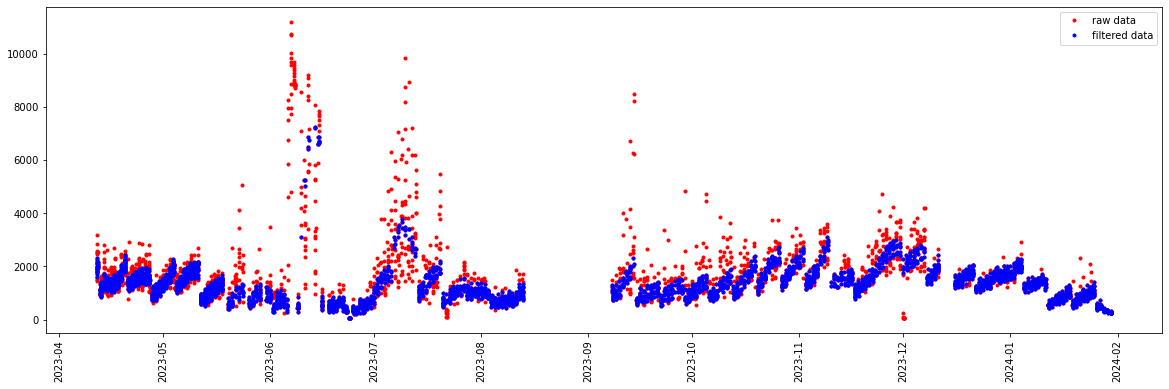

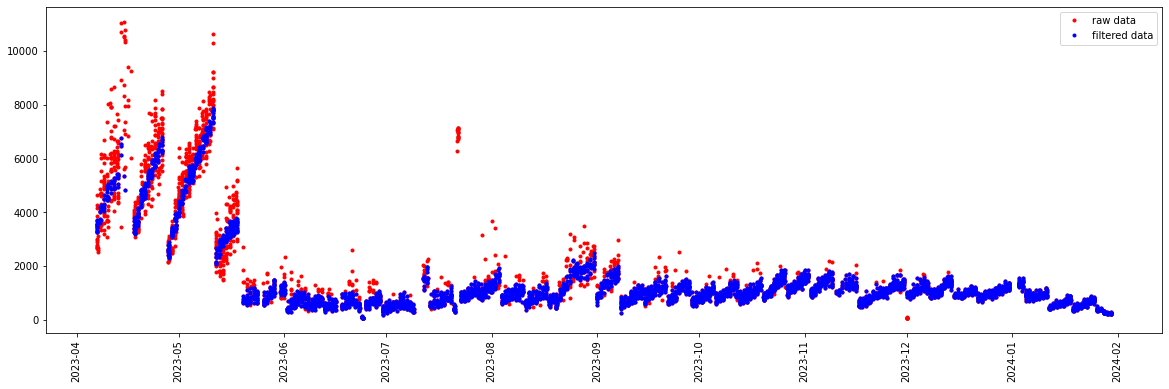

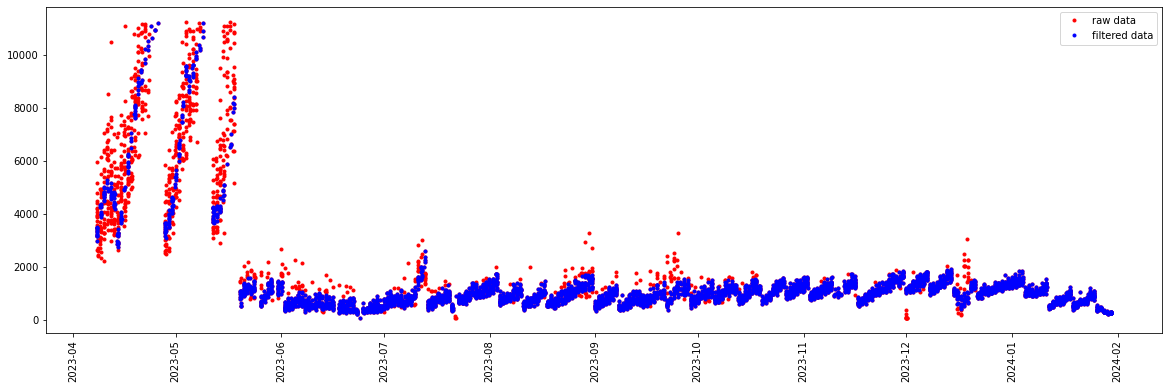

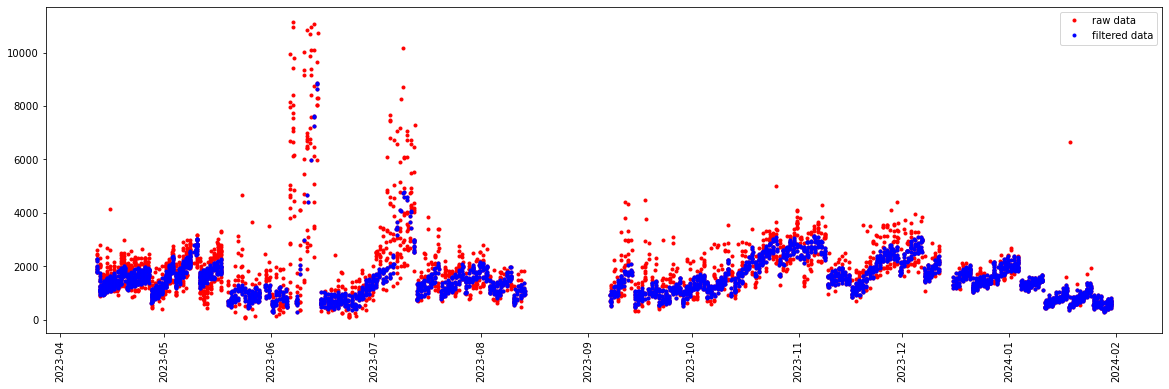

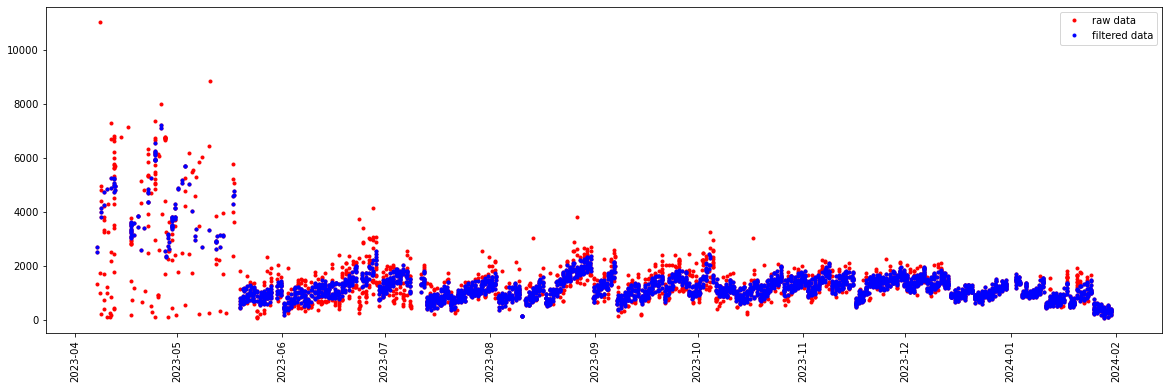

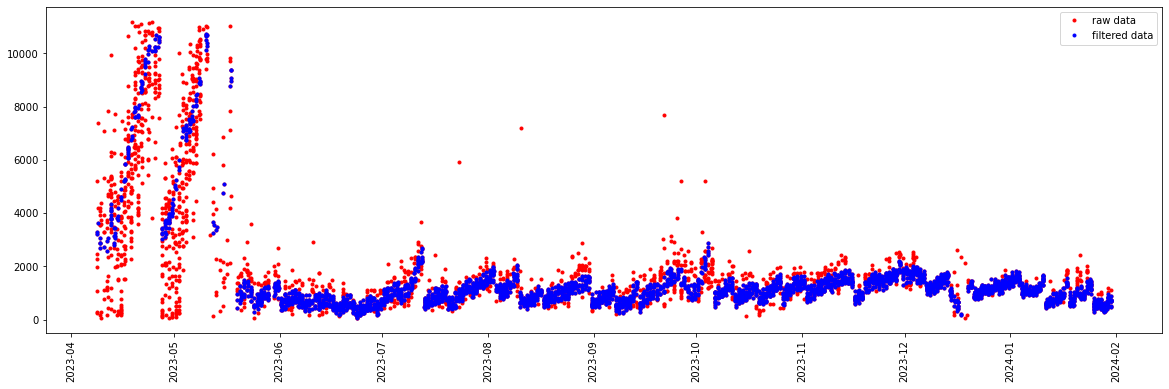

In [156]:
plot_sensor_result(sensor1_night, sensor1_clean_night)
plot_sensor_result(sensor4_night, sensor4_clean_night)
plot_sensor_result(sensor5_night, sensor5_clean_night)

plot_sensor_result(sensor1_day, sensor1_clean_day)
plot_sensor_result(sensor4_day, sensor4_clean_day)
plot_sensor_result(sensor5_day, sensor5_clean_day)

## Output before filter

In [145]:
sensor1_avg_night = average_by_hours(sensor1_night, dates = 'dates', param = 'delta', result = 'avg_clean', hours = 3)
sensor4_avg_night = average_by_hours(sensor4_night, dates = 'dates', param = 'delta', result = 'avg_clean', hours = 3)
sensor5_avg_night = average_by_hours(sensor5_night, dates = 'dates', param = 'delta', result = 'avg_clean', hours = 3)

sensor1_avg_day = average_by_hours(sensor1_day, dates = 'dates', param = 'delta', result = 'avg_clean', hours = 3)
sensor4_avg_day = average_by_hours(sensor4_day, dates = 'dates', param = 'delta', result = 'avg_clean', hours = 3)
sensor5_avg_day = average_by_hours(sensor5_day, dates = 'dates', param = 'delta', result = 'avg_clean', hours = 3)

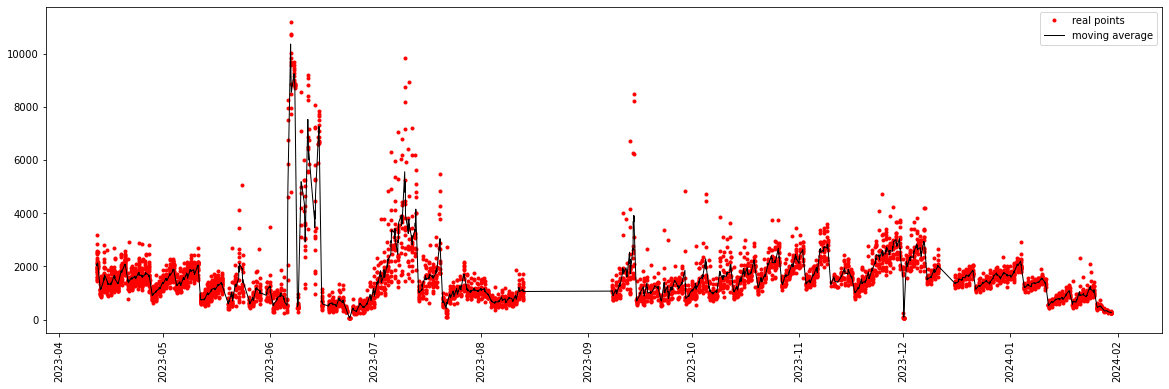

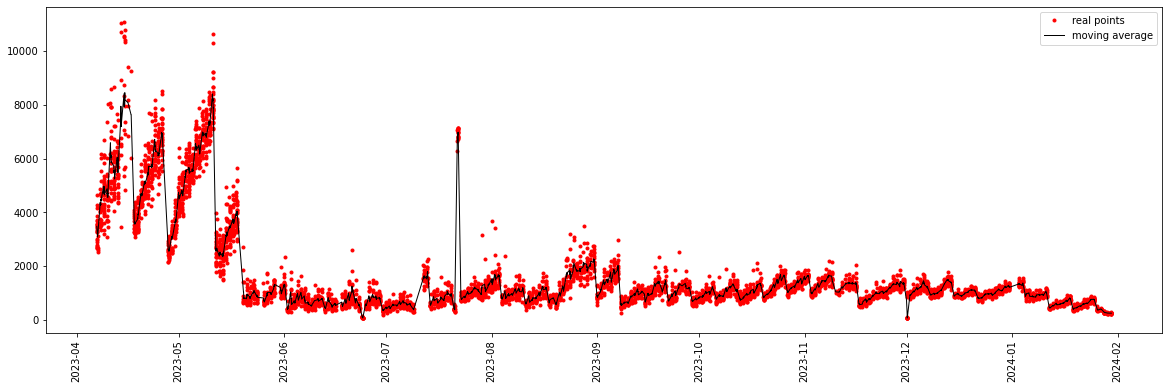

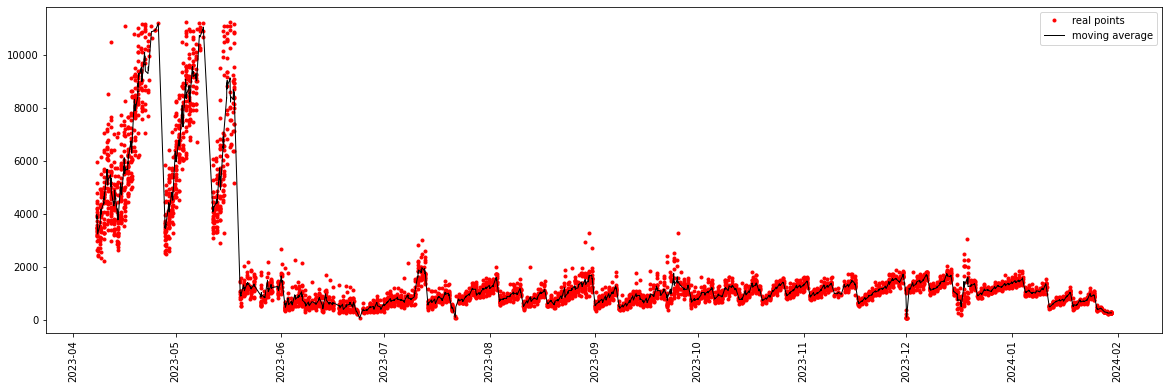

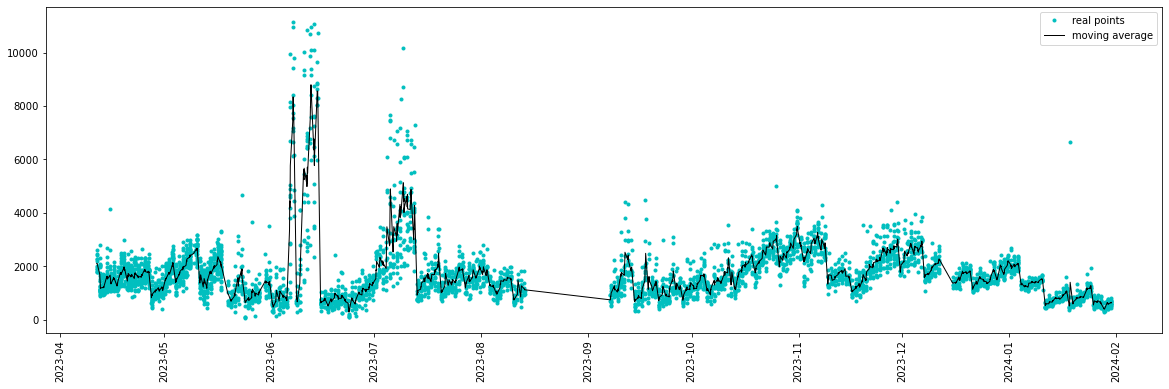

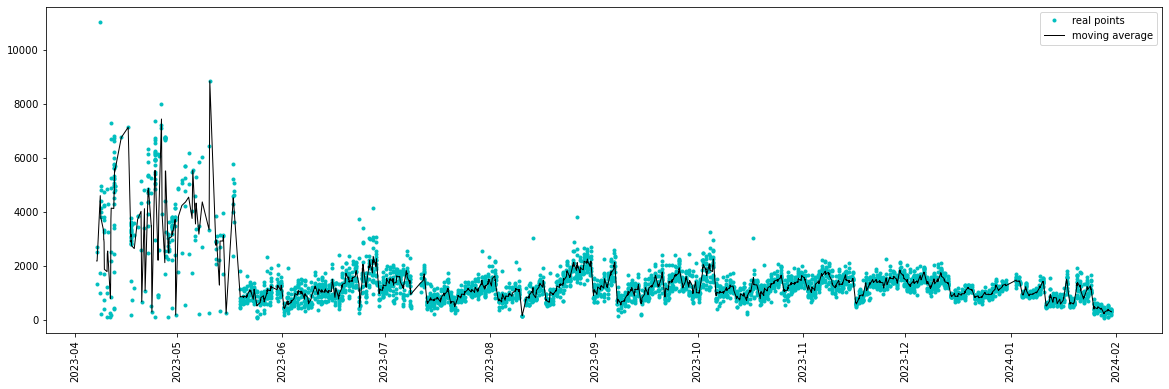

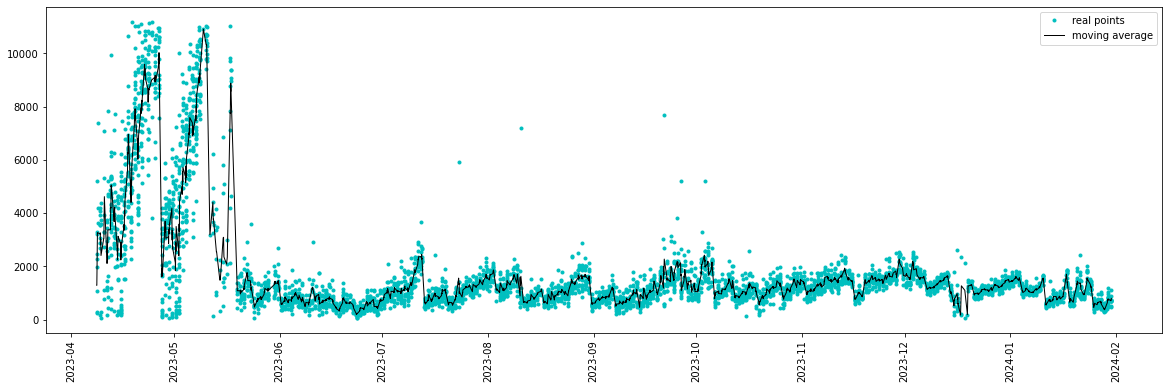

In [157]:
plot_sensor_clean(sensor1_avg_night, nonfilter_color = 'r', filter_color = 'k')
plot_sensor_clean(sensor4_avg_night, nonfilter_color = 'r', filter_color = 'k')
plot_sensor_clean(sensor5_avg_night, nonfilter_color = 'r', filter_color = 'k')

plot_sensor_clean(sensor1_avg_day, nonfilter_color = 'c', filter_color = 'k')
plot_sensor_clean(sensor4_avg_day, nonfilter_color = 'c', filter_color = 'k')
plot_sensor_clean(sensor5_avg_day, nonfilter_color = 'c', filter_color = 'k')

## Output After Filter

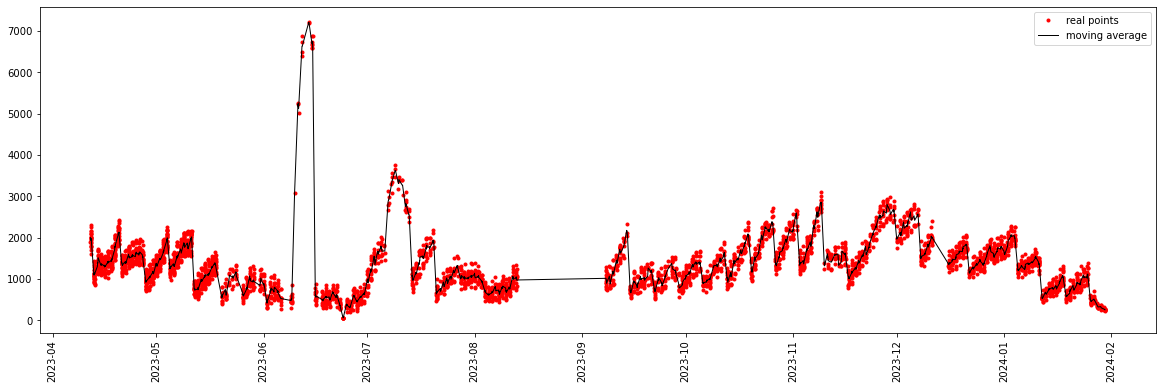

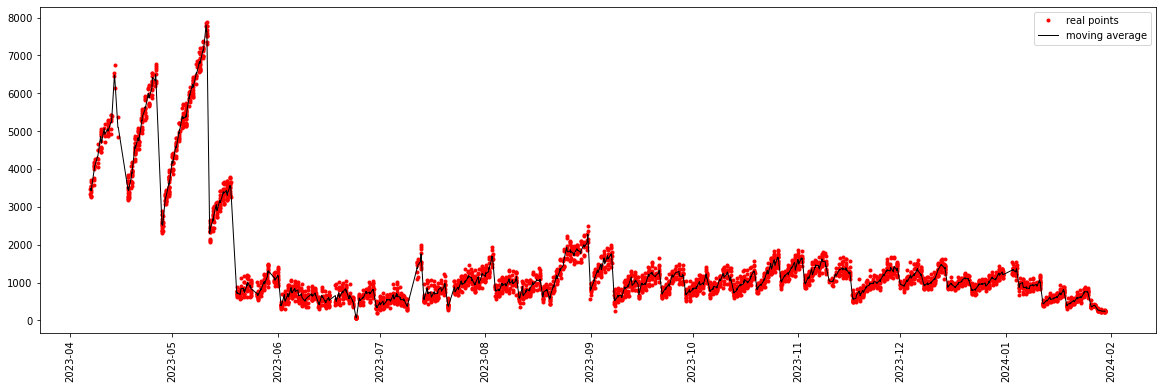

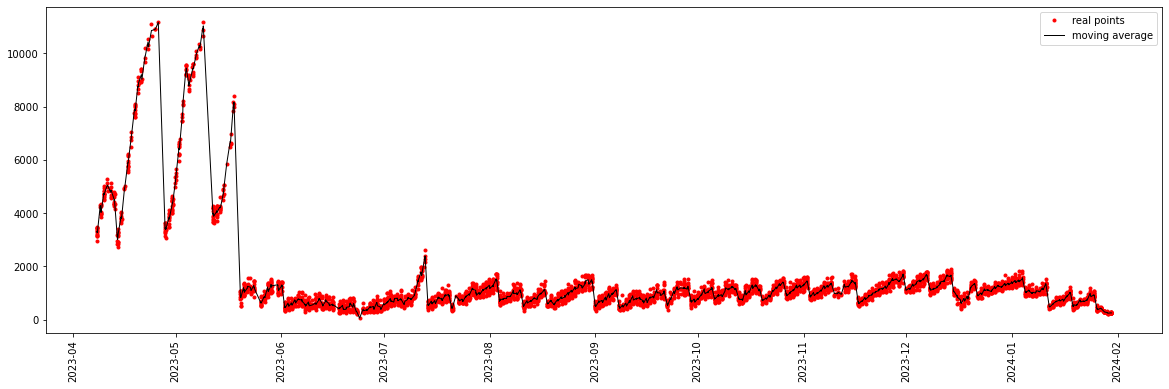

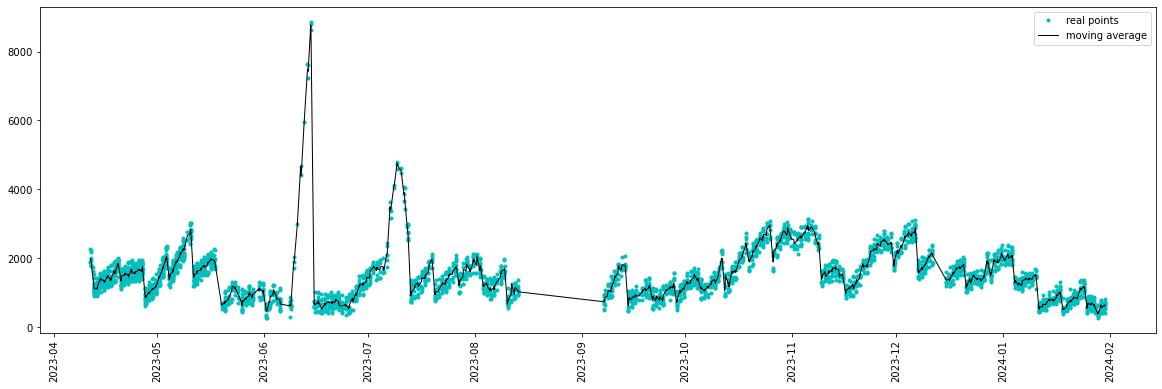

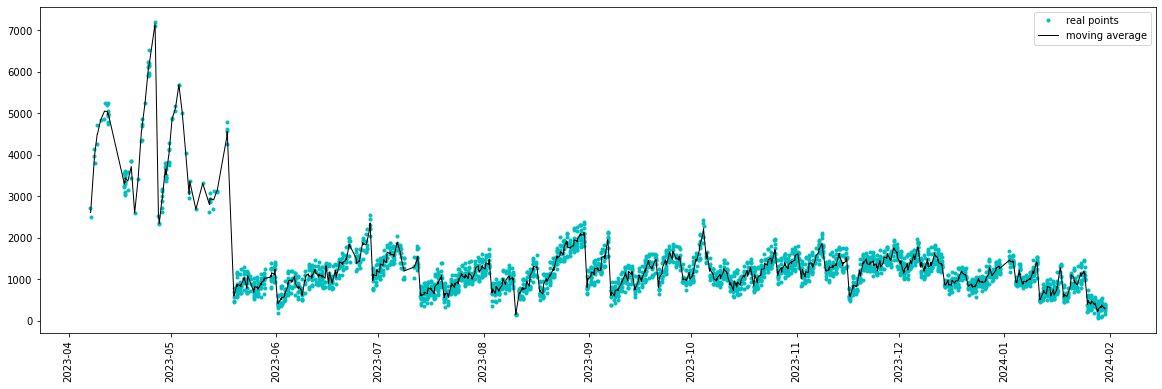

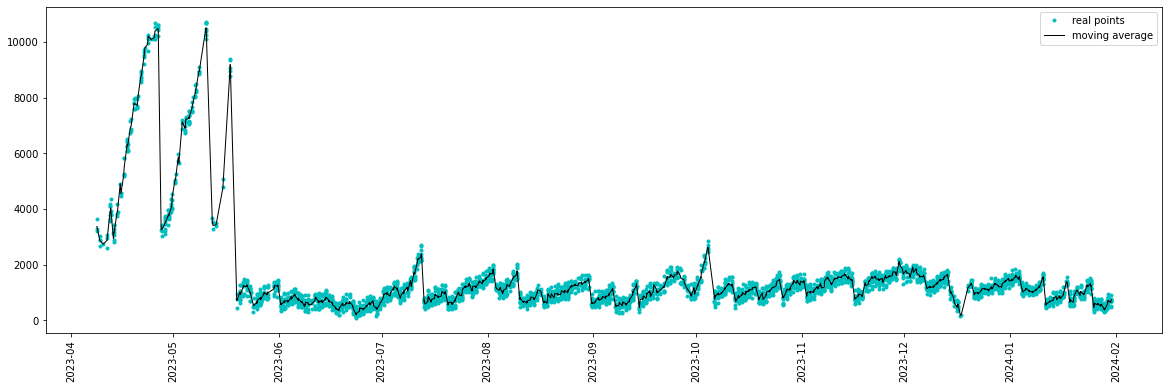

In [158]:
plot_sensor_clean(sensor1_clean_night, nonfilter_color = 'r', filter_color = 'k')
plot_sensor_clean(sensor4_clean_night, nonfilter_color = 'r', filter_color = 'k')
plot_sensor_clean(sensor5_clean_night, nonfilter_color = 'r', filter_color = 'k')

plot_sensor_clean(sensor1_clean_day, nonfilter_color = 'c', filter_color = 'k')
plot_sensor_clean(sensor4_clean_day, nonfilter_color = 'c', filter_color = 'k')
plot_sensor_clean(sensor5_clean_day, nonfilter_color = 'c', filter_color = 'k')

## Compare 2 average

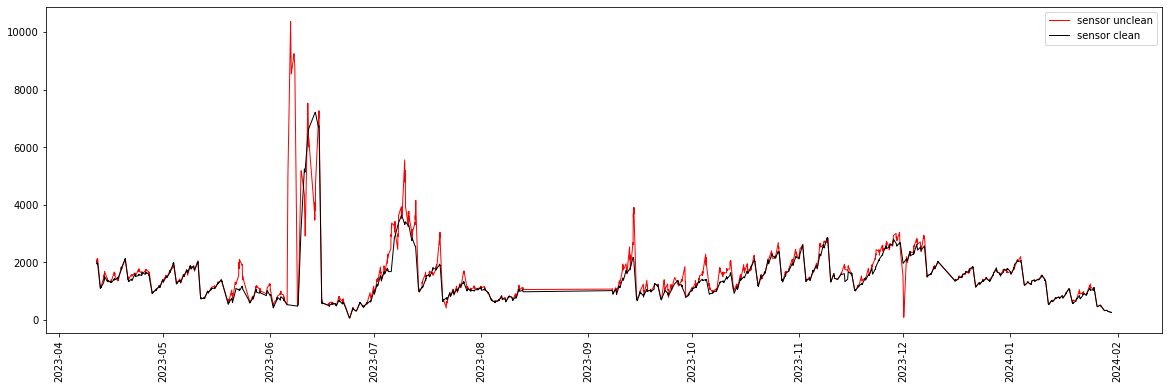

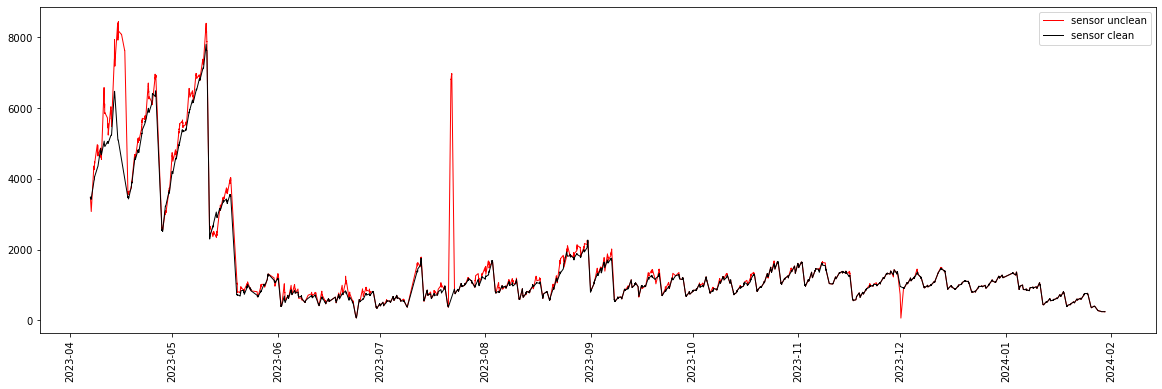

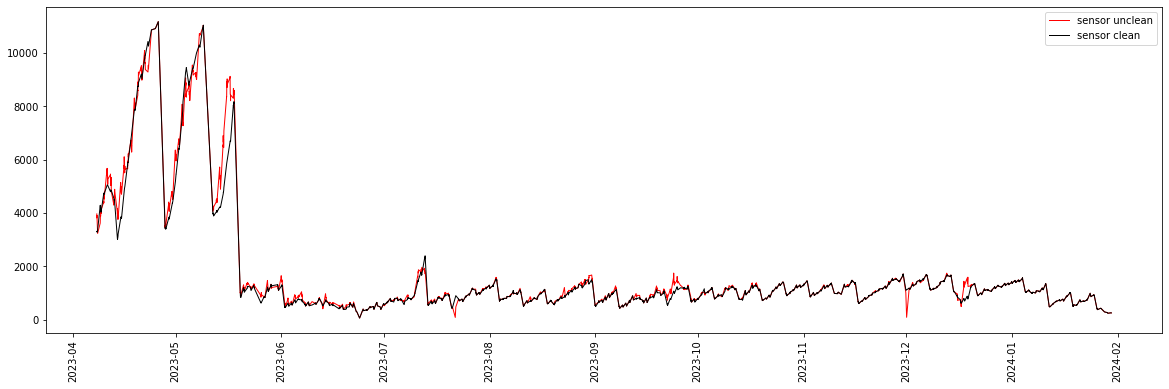

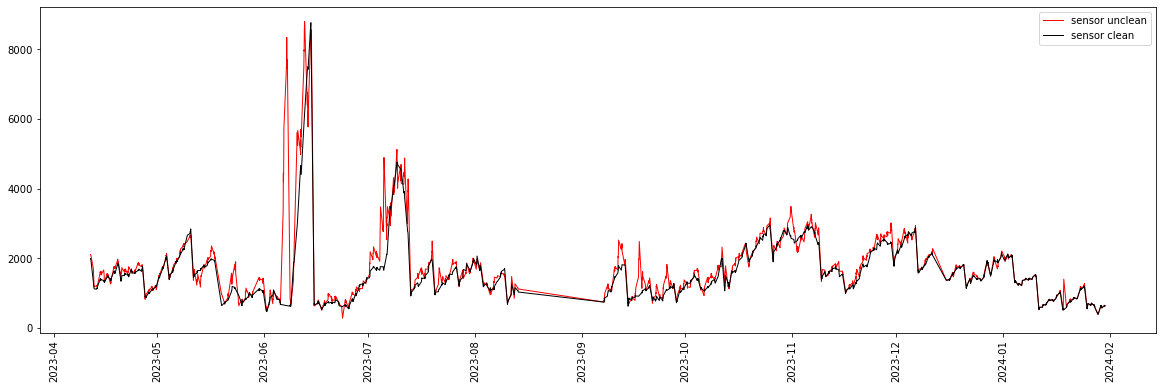

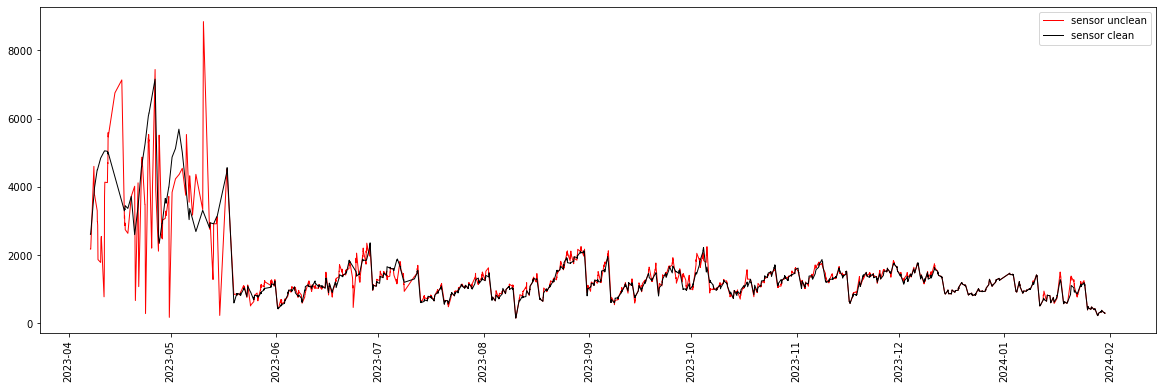

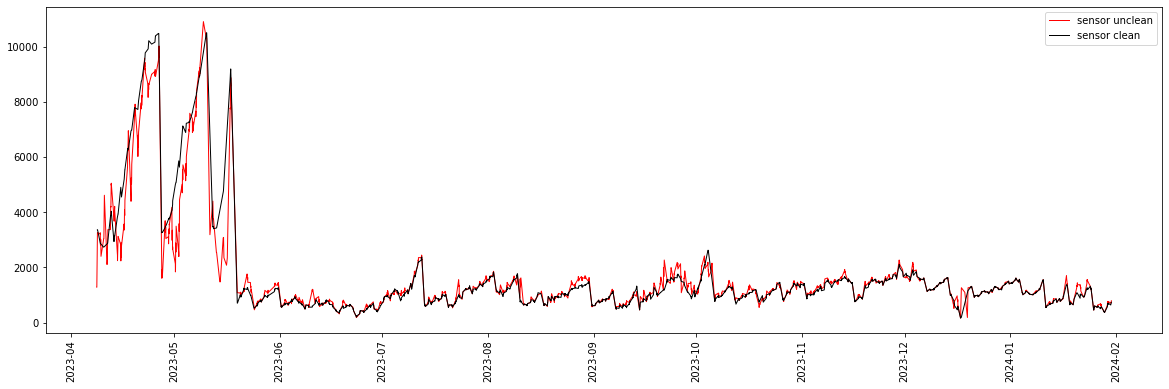

In [159]:
plot_sensor_avg_compare(sensor1_avg_night, sensor1_clean_night)
plot_sensor_avg_compare(sensor4_avg_night, sensor4_clean_night)
plot_sensor_avg_compare(sensor5_avg_night, sensor5_clean_night)

plot_sensor_avg_compare(sensor1_avg_day, sensor1_clean_day)
plot_sensor_avg_compare(sensor4_avg_day, sensor4_clean_day)
plot_sensor_avg_compare(sensor5_avg_day, sensor5_clean_day)

# Save the clean data (not necessary)

In [24]:
sensor1_clean_night.to_csv('sensor1_clean_night_raw.csv', index=False)
sensor4_clean_night.to_csv('sensor4_clean_night_raw.csv', index=False)
sensor5_clean_night.to_csv('sensor5_clean_night_raw.csv', index=False)

sensor1_clean_day.to_csv('sensor1_clean_day_raw.csv', index=False)
sensor4_clean_day.to_csv('sensor4_clean_day_raw.csv', index=False)
sensor5_clean_day.to_csv('sensor5_clean_day_raw.csv', index=False)

# Add weather data

Data contains:
- Temp
- Pressure
- Humidity
- Solar_radiation

You can modify for using support weather data as you want, I have csv file which collect average data every 1 hour as:

datetime, Temp, Pressure, Humidity, Solar_radiation

2023-03-29 13:20:15-04:00, 15.966667, 1018.325000, 63.666667, 777.166667

In [68]:
df_weather = pd.read_csv('weather.csv')
# df_weather.set_index('datetime', inplace=True)
df_weather['dates'] = pd.to_datetime(df_weather['datetime'], utc=True)
df_weather.head()

,Unnamed: 0,Temp,Pressure,Humidity,Solar_radiation,datetime,dates
0,0,NaN,NaN,NaN,NaN,2023-03-29 13:00:00-04:00,2023-03-29 17:00:00+00:00
1,1,NaN,NaN,NaN,NaN,2023-03-29 14:00:00-04:00,2023-03-29 18:00:00+00:00
2,2,NaN,NaN,NaN,NaN,2023-03-29 15:00:00-04:00,2023-03-29 19:00:00+00:00
3,3,NaN,NaN,NaN,NaN,2023-03-29 16:00:00-04:00,2023-03-29 20:00:00+00:00
4,4,25.55,1018.375,73.25,849.25,2023-03-29 17:00:00-04:00,2023-03-29 21:00:00+00:00


In [83]:
def add_weather_forecast(sensor, df_weather):
    df_weather['y'] = pd.to_datetime(df_weather['dates']).dt.year
    df_weather['m'] = pd.to_datetime(df_weather['dates']).dt.month
    df_weather['d'] = pd.to_datetime(df_weather['dates']).dt.day
    df_weather['H'] = pd.to_datetime(df_weather['dates']).dt.hour
    sensor['Temp'] = np.nan
    sensor['Pressure'] = np.nan
    sensor['Humidity'] = np.nan
    sensor['Solar_radiation'] = np.nan
    for i in range(len(sensor)):
        selected_datetime = pd.to_datetime(sensor['dates'].iloc[i])
        day_value = selected_datetime.day
        month_value = selected_datetime.month
        year_value = selected_datetime.year
        hour_value = selected_datetime.hour
        rows = df_weather[df_weather['y'] == year_value]
        if len(rows) == 0:
            continue
        rows = rows[df_weather['m'] == month_value]
        if len(rows) == 0:
            continue
        rows = rows[df_weather['d'] == day_value]
        if len(rows) == 0:
            continue
        rows = rows[df_weather['H'] == hour_value]
#         print(rows)
        if len(rows) >= 1:
            sensor['Temp'].iloc[i] = rows['Temp'].iloc[0]
            sensor['Pressure'].iloc[i] = rows['Pressure'].iloc[0]
            sensor['Humidity'].iloc[i] = rows['Humidity'].iloc[0]
            sensor['Solar_radiation'].iloc[i] = rows['Solar_radiation'].iloc[0]
        
    return sensor

## Cleaned data

In [85]:
sensor1_night_weather = add_weather_forecast(sensor1_clean_night, df_weather)
sensor4_night_weather = add_weather_forecast(sensor4_clean_night, df_weather)
sensor5_night_weather = add_weather_forecast(sensor5_clean_night, df_weather)

sensor1_day_weather = add_weather_forecast(sensor1_clean_day, df_weather)
sensor4_day_weather = add_weather_forecast(sensor4_clean_day, df_weather)
sensor5_day_weather = add_weather_forecast(sensor5_clean_day, df_weather)

In [86]:
sensor1_night_weather.to_csv('sensor1_w_night_raw.csv', index=False)
sensor4_night_weather.to_csv('sensor4_w_night_raw.csv', index=False)
sensor5_night_weather.to_csv('sensor5_w_night_raw.csv', index=False)

sensor1_day_weather.to_csv('sensor1_w_day_raw.csv', index=False)
sensor4_day_weather.to_csv('sensor4_w_day_raw.csv', index=False)
sensor5_day_weather.to_csv('sensor5_w_day_raw.csv', index=False)

## Unclean data

In [160]:
sensor1_night_weather_u = add_weather_forecast(sensor1_avg_night, df_weather)
sensor4_night_weather_u = add_weather_forecast(sensor4_avg_night, df_weather)
sensor5_night_weather_u = add_weather_forecast(sensor5_avg_night, df_weather)

sensor1_day_weather_u = add_weather_forecast(sensor1_avg_day, df_weather)
sensor4_day_weather_u = add_weather_forecast(sensor4_avg_day, df_weather)
sensor5_day_weather_u = add_weather_forecast(sensor5_avg_day, df_weather)

In [161]:
sensor1_night_weather_u.to_csv('sensor1_w_u_night_raw.csv', index=False)
sensor4_night_weather_u.to_csv('sensor4_w_u_night_raw.csv', index=False)
sensor5_night_weather_u.to_csv('sensor5_w_u_night_raw.csv', index=False)

sensor1_day_weather_u.to_csv('sensor1_w_u_day_raw.csv', index=False)
sensor4_day_weather_u.to_csv('sensor4_w_u_day_raw.csv', index=False)
sensor5_day_weather_u.to_csv('sensor5_w_u_day_raw.csv', index=False)

# Combine harvest data information

In [114]:
# load sensor log, harvest data
df_sensor = pd.read_csv('sensor_log.csv')
df_harvest_manual = pd.read_csv('manual_harvest_data.csv')

In [137]:
def initialize_harvest_columns(sensor1_clean):
    sensor1_clean['harvest'] = np.NaN
    sensor1_clean['tank'] = np.NaN
    sensor1_clean['status_harvest'] = np.NaN
    return sensor1_clean

def get_sensor_by_id(df_sensor):
    df_sensor['datetime'] = to_datetime(df_sensor.Date)
    df_sensor_1 = df_sensor[df_sensor['ID'] == 1]
    df_sensor_2 = df_sensor[df_sensor['ID'] == 2]
    df_sensor_3 = df_sensor[df_sensor['ID'] == 3]
    df_sensor_4 = df_sensor[df_sensor['ID'] == 4]
    df_sensor_5 = df_sensor[df_sensor['ID'] == 5]
    return df_sensor_1, df_sensor_2, df_sensor_3, df_sensor_4, df_sensor_5

def set_tank_number(sensor1_clean, df_sensor_1):
    sensor1_clean.sort_index()
    df_sensor_1.sort_index()
    # print(df_sensor_1)
    for i in range(len(df_sensor_1)):
        tank = df_sensor_1['Value'].iloc[i]
        if df_sensor_1['Event'].iloc[i] == 'r':
    #         print('r')
            sensor1_clean.loc[sensor1_clean["dates"] >= df_sensor_1['datetime'].iloc[i], "tank"] = "0"
        elif df_sensor_1['Event'].iloc[i] == 'i':
    #         print('i')
#             print(df_sensor_1['datetime'].iloc[i])
            sensor1_clean.loc[sensor1_clean["dates"] >= df_sensor_1['datetime'].iloc[i], "tank"] = tank
    return sensor1_clean

def sep_tank_num(sensor1_clean):
    sensor1_t1 = sensor1_clean[sensor1_clean['tank'] == 1]
    sensor1_t2 = sensor1_clean[sensor1_clean['tank'] == 2]
    sensor1_t3 = sensor1_clean[sensor1_clean['tank'] == 3]
    sensor1_t4 = sensor1_clean[sensor1_clean['tank'] == 4]
    sensor1_t5 = sensor1_clean[sensor1_clean['tank'] == 5]
    sensor1_t6 = sensor1_clean[sensor1_clean['tank'] == 6]
    sensor1_t7 = sensor1_clean[sensor1_clean['tank'] == 7]
    sensor1_t8 = sensor1_clean[sensor1_clean['tank'] == 8]
    return sensor1_t1, sensor1_t2, sensor1_t3, sensor1_t4, sensor1_t5, sensor1_t6, sensor1_t7, sensor1_t8

def add_harvest_by_tank(sensor1_t1, df_harvest_manual, tankID):
    # change date non format to datetime
    df_harvest_manual['datetime'] = None
    for i in range(len(df_harvest_manual)):
        date = df_harvest_manual['Date'].iloc[i]
        m, d, y = date.split('.')
        date_string = m + "/" + d + "/" + y + " 10:00"
        date_object = pd.to_datetime(date_string, format="%m/%d/%y %H:%M").tz_localize('America/New_York')
        df_harvest_manual['datetime'].iloc[i] = date_object

    for i in range(len(df_harvest_manual)):
        if df_harvest_manual['Tank ID'].iloc[i] != tankID:
            continue
            
        status = ''    # empty = -1, restock = 1, seaweed remain = 2
        if pd.notna(df_harvest_manual['Comments'].iloc[i]) and 'remained empty' in df_harvest_manual['Comments'].iloc[i].lower():
            status = 'remained empty'
        if pd.notna(df_harvest_manual['Comments'].iloc[i]) and 'restock' in df_harvest_manual['Comments'].iloc[i].lower():
            status = 'restock'
        elif pd.notna(df_harvest_manual['Comments'].iloc[i]) and 'empty' in df_harvest_manual['Comments'].iloc[i].lower():
            status = 'empty'
        else:
            status = 'harvest'
            
        dt = df_harvest_manual['datetime'].iloc[i]
        if status == 'remained empty':
            new_row = {'dates': dt, 'harvest': 0, 'status_harvest': status}
            sensor1_t1 = sensor1_t1.append(new_row, ignore_index=True)
        elif status == 'harvest':
            new_row = {'dates': dt, 'harvest': -df_harvest_manual['Removed (kg)'].iloc[i], 'status_harvest': status}
            sensor1_t1 = sensor1_t1.append(new_row, ignore_index=True)
        elif status == 'empty':
            new_row = {'dates': dt, 'harvest': -df_harvest_manual['Removed (kg)'].iloc[i], 'status_harvest': status}
            sensor1_t1 = sensor1_t1.append(new_row, ignore_index=True)
        elif status == 'restock':
            # add empty and restock
            new_row = {'dates': dt, 'harvest': -df_harvest_manual['Removed (kg)'].iloc[i], 'status_harvest': 'empty'}
            sensor1_t1 = sensor1_t1.append(new_row, ignore_index=True)
            new_row = {'dates': dt, 'harvest': df_harvest_manual['After Harvest (kg)'].iloc[i], 'status_harvest': status}
            sensor1_t1 = sensor1_t1.append(new_row, ignore_index=True)
            
    sensor1_t1 = sensor1_t1.sort_values(by='dates').reset_index(drop=True)
    return sensor1_t1

# Get sensor log by sensor number

In [110]:
df_sensor_1, df_sensor_2, df_sensor_3, df_sensor_4, df_sensor_5 = get_sensor_by_id(df_sensor)

## Clean data

### Initialize

In [109]:
sensor1_night_weather = initialize_harvest_columns(sensor1_night_weather)
sensor4_night_weather = initialize_harvest_columns(sensor4_night_weather)
sensor5_night_weather = initialize_harvest_columns(sensor5_night_weather)

sensor1_day_weather = initialize_harvest_columns(sensor1_day_weather)
sensor4_day_weather = initialize_harvest_columns(sensor4_day_weather)
sensor5_day_weather = initialize_harvest_columns(sensor5_day_weather)

### Input tank number into dataframe and separate them

In [111]:
sensor1_clean_night = set_tank_number(sensor1_night_weather, df_sensor_1)
sensor4_clean_night = set_tank_number(sensor4_night_weather, df_sensor_4)
sensor5_clean_night = set_tank_number(sensor5_night_weather, df_sensor_5)

sensor1_clean_day = set_tank_number(sensor1_day_weather, df_sensor_1)
sensor4_clean_day = set_tank_number(sensor4_day_weather, df_sensor_4)
sensor5_clean_day = set_tank_number(sensor5_day_weather, df_sensor_5)

s1n = sep_tank_num(sensor1_clean_night)
s4n = sep_tank_num(sensor4_clean_night)
s5n = sep_tank_num(sensor5_clean_night)

s1d = sep_tank_num(sensor1_clean_day)
s4d = sep_tank_num(sensor4_clean_day)
s5d = sep_tank_num(sensor5_clean_day)

In [112]:
# check sensor 1 tank 5
s1n[4].head()

,dates,on,off,g_val,times,avg,delta,int_dates,distance,avg_clean,Temp,Pressure,Humidity,Solar_radiation,harvest,tank,status_harvest
11462,2023-08-10 22:18:45-04:00,44,0,808,22:18:45,909.777778,808,1065995898,104.984375,792.500000,34.361538,1015.276923,65.230769,482.846154,NaN,5,NaN
11463,2023-08-10 22:41:20-04:00,80,0,691,22:41:20,907.100000,691,1065995921,20.750000,802.555556,34.361538,1015.276923,65.230769,482.846154,NaN,5,NaN
11464,2023-08-10 23:03:24-04:00,15,0,715,23:03:24,898.454545,715,1065995943,5.023438,803.500000,30.545455,1014.618182,74.727273,156.636364,NaN,5,NaN
11465,2023-08-10 23:25:29-04:00,20,0,770,23:25:29,881.500000,770,1065995965,41.789062,793.636364,30.545455,1014.618182,74.727273,156.636364,NaN,5,NaN
11466,2023-08-10 23:47:34-04:00,15,0,961,23:47:34,858.076923,961,1065995987,224.695312,775.583333,30.545455,1014.618182,74.727273,156.636364,NaN,5,NaN


### Add harvest data

In [138]:
s1nh = []
s4nh = []
s5nh = []
s1dh = []
s4dh = []
s5dh = []
for i in range(8):
    sx = add_harvest_by_tank(s1n[i], df_harvest_manual, i + 1)
    s1nh.append(sx)
    sx = add_harvest_by_tank(s4n[i], df_harvest_manual, i + 1)
    s4nh.append(sx)
    sx = add_harvest_by_tank(s5n[i], df_harvest_manual, i + 1)
    s5nh.append(sx)
    sx = add_harvest_by_tank(s1d[i], df_harvest_manual, i + 1)
    s1dh.append(sx)
    sx = add_harvest_by_tank(s4d[i], df_harvest_manual, i + 1)
    s4dh.append(sx)
    sx = add_harvest_by_tank(s5d[i], df_harvest_manual, i + 1)
    s5dh.append(sx)

In [136]:
s1dh[4].head()

,dates,on,off,g_val,times,avg,delta,int_dates,distance,avg_clean,Temp,Pressure,Humidity,Solar_radiation,harvest,tank,status_harvest
0,2023-03-09 10:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.70,NaN,harvest
1,2023-03-09 10:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.70,NaN,harvest
2,2023-03-16 10:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.30,NaN,harvest
3,2023-03-16 10:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.30,NaN,harvest
4,2023-03-23 10:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-63.81,NaN,empty


### Save harvest data

- s = sensor number
- t = tank number
- n = night time
- d = day time
- u = unclean data

In [139]:
for i in range(8):
    s1nh[i].to_csv('s1t' + str(i+1) + 'n.csv', index=False)
    s4nh[i].to_csv('s4t' + str(i+1) + 'n.csv', index=False)
    s5nh[i].to_csv('s5t' + str(i+1) + 'n.csv', index=False)
    
    s1dh[i].to_csv('s1t' + str(i+1) + 'd.csv', index=False)
    s4dh[i].to_csv('s4t' + str(i+1) + 'd.csv', index=False)
    s5dh[i].to_csv('s5t' + str(i+1) + 'd.csv', index=False)

## Unclean data

### Initialize

In [162]:
sensor1_night_weather_u = initialize_harvest_columns(sensor1_night_weather_u)
sensor4_night_weather_u = initialize_harvest_columns(sensor4_night_weather_u)
sensor5_night_weather_u = initialize_harvest_columns(sensor5_night_weather_u)

sensor1_day_weather_u = initialize_harvest_columns(sensor1_day_weather_u)
sensor4_day_weather_u = initialize_harvest_columns(sensor4_day_weather_u)
sensor5_day_weather_u = initialize_harvest_columns(sensor5_day_weather_u)

### Input tank number into dataframe and separate them

In [163]:
sensor1_clean_night_u = set_tank_number(sensor1_night_weather_u, df_sensor_1)
sensor4_clean_night_u = set_tank_number(sensor4_night_weather_u, df_sensor_4)
sensor5_clean_night_u = set_tank_number(sensor5_night_weather_u, df_sensor_5)

sensor1_clean_day_u = set_tank_number(sensor1_day_weather_u, df_sensor_1)
sensor4_clean_day_u = set_tank_number(sensor4_day_weather_u, df_sensor_4)
sensor5_clean_day_u = set_tank_number(sensor5_day_weather_u, df_sensor_5)

s1n_u = sep_tank_num(sensor1_clean_night_u)
s4n_u = sep_tank_num(sensor4_clean_night_u)
s5n_u = sep_tank_num(sensor5_clean_night_u)

s1d_u = sep_tank_num(sensor1_clean_day_u)
s4d_u = sep_tank_num(sensor4_clean_day_u)
s5d_u = sep_tank_num(sensor5_clean_day_u)

### Add Harvest data

In [164]:
s1nh_u = []
s4nh_u = []
s5nh_u = []
s1dh_u = []
s4dh_u = []
s5dh_u = []
for i in range(8):
    sx = add_harvest_by_tank(s1n_u[i], df_harvest_manual, i + 1)
    s1nh_u.append(sx)
    sx = add_harvest_by_tank(s4n_u[i], df_harvest_manual, i + 1)
    s4nh_u.append(sx)
    sx = add_harvest_by_tank(s5n_u[i], df_harvest_manual, i + 1)
    s5nh_u.append(sx)
    sx = add_harvest_by_tank(s1d_u[i], df_harvest_manual, i + 1)
    s1dh_u.append(sx)
    sx = add_harvest_by_tank(s4d_u[i], df_harvest_manual, i + 1)
    s4dh_u.append(sx)
    sx = add_harvest_by_tank(s5d_u[i], df_harvest_manual, i + 1)
    s5dh_u.append(sx)

In [165]:
for i in range(8):
    s1nh_u[i].to_csv('s1t' + str(i+1) + 'n_u.csv', index=False)
    s4nh_u[i].to_csv('s4t' + str(i+1) + 'n_u.csv', index=False)
    s5nh_u[i].to_csv('s5t' + str(i+1) + 'n_u.csv', index=False)
    
    s1dh_u[i].to_csv('s1t' + str(i+1) + 'd_u.csv', index=False)
    s4dh_u[i].to_csv('s4t' + str(i+1) + 'd_u.csv', index=False)
    s5dh_u[i].to_csv('s5t' + str(i+1) + 'd_u.csv', index=False)

# Filter empty, separate period of process

In [204]:
def filter_empty(sensor_with_harvest):
    test = sensor_with_harvest[(sensor_with_harvest['status_harvest'] != 'empty') | ~sensor_with_harvest['harvest'].isna()]
    test = test[test['harvest'] != 0]
#     test1 = test.dropna(subset=['harvest'])
#     print(test1)
    return test

def separate_period(sensor_with_harvest):
    sss = []
    sx = filter_empty(sensor_with_harvest)
    while True:
#         print(len(sx))
        if (len(sx) == 0):
            break
        first_restock_index = (sx['status_harvest'] == 'restock').idxmax()
        if first_restock_index > 0:
            df0 = sx.loc[:first_restock_index-1]
            sss.append(df0)
        else:
            df0 = None
        df1 = sx.loc[first_restock_index:]

        end_restock_index = (df1['status_harvest'] == 'empty').idxmax()
        if end_restock_index <= 0:
            # no df2
            df2 = None
            sss.append(df1)
            break
        else:
            df2 = df1.loc[end_restock_index + 1:]
            df1 = df1.loc[:end_restock_index]
            sss.append(df1)
        sx = df2
    return sss

In [205]:
s1nh_sep = []
s4nh_sep = []
s5nh_sep = []

s1dh_sep = []
s4dh_sep = []
s5dh_sep = []

s1nh_sep_u = []
s4nh_sep_u = []
s5nh_sep_u = []

s1dh_sep_u = []
s4dh_sep_u = []
s5dh_sep_u = []

for i in range(8):
    sx = filter_empty(s1nh[i])
    snh_sep = separate_period(sx)
    s1nh_sep.append(snh_sep)
    
    sx = filter_empty(s4nh[i])
    snh_sep = separate_period(sx)
    s4nh_sep.append(snh_sep)
    
    sx = filter_empty(s5nh[i])
    snh_sep = separate_period(sx)
    s5nh_sep.append(snh_sep)
    
    sx = filter_empty(s1dh[i])
    snh_sep = separate_period(sx)
    s1dh_sep.append(snh_sep)
    
    sx = filter_empty(s4dh[i])
    snh_sep = separate_period(sx)
    s4dh_sep.append(snh_sep)
    
    sx = filter_empty(s5dh[i])
    snh_sep = separate_period(sx)
    s5dh_sep.append(snh_sep)
    
    sx = filter_empty(s1nh_u[i])
    snh_sep = separate_period(sx)
    s1nh_sep_u.append(snh_sep)
    
    sx = filter_empty(s4nh_u[i])
    snh_sep = separate_period(sx)
    s4nh_sep_u.append(snh_sep)
    
    sx = filter_empty(s5nh_u[i])
    snh_sep = separate_period(sx)
    s5nh_sep_u.append(snh_sep)
    
    sx = filter_empty(s1dh_u[i])
    snh_sep = separate_period(sx)
    s1dh_sep_u.append(snh_sep)
    
    sx = filter_empty(s4dh_u[i])
    snh_sep = separate_period(sx)
    s4dh_sep_u.append(snh_sep)
    
    sx = filter_empty(s5dh_u[i])
    snh_sep = separate_period(sx)
    s5dh_sep_u.append(snh_sep)

# Create folders

In [214]:
import os

def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [215]:
folder_path = "final"
create_folder(folder_path)

for i in range(5):
    create_folder(folder_path + '/sensor' + str(i+1))
    for j in range(8):
        create_folder(folder_path + '/sensor' + str(i+1) + '/tank' + str(j+1))

In [216]:
folder_path = "final"
for i in range(8):
    for sx in s1nh_sep[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor1/tank' + str(i+1) + '/s1t' + str(i+1) + 'n_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s4nh_sep[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor4/tank' + str(i+1) + '/s4t' + str(i+1) + 'n_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s5nh_sep[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor5/tank' + str(i+1) + '/s5t' + str(i+1) + 'n_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s1dh_sep[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor1/tank' + str(i+1) + '/s1t' + str(i+1) + 'd_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s4dh_sep[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor4/tank' + str(i+1) + '/s4t' + str(i+1) + 'd_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s5dh_sep[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor5/tank' + str(i+1) + '/s5t' + str(i+1) + 'd_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s1nh_sep_u[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor1/tank' + str(i+1) + '/s1t' + str(i+1) + 'n_u_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s4nh_sep_u[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor4/tank' + str(i+1) + '/s4t' + str(i+1) + 'n_u_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s5nh_sep_u[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor5/tank' + str(i+1) + '/s5t' + str(i+1) + 'n_u_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s1dh_sep_u[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor1/tank' + str(i+1) + '/s1t' + str(i+1) + 'd_u_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s4dh_sep_u[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor4/tank' + str(i+1) + '/s4t' + str(i+1) + 'd_u_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    for sx in s5dh_sep_u[i]:
        if len(sx) > 2:
            dt = sx['dates'].iloc[0]
            sx.to_csv(folder_path + '/sensor5/tank' + str(i+1) + '/s5t' + str(i+1) + 'd_u_' + str(dt.year) + str(dt.month) + str(dt.day) + '.csv', index=False)
    
    